# Read annotation from VGG Image Annotator (VIA)

http://www.robots.ox.ac.uk/~vgg/software/via/

`io3d` package is used for dataset path control on various machines. The default dataset path is in user home:

```
~/data/medical/orig/GBM/
```

it can indiviually changed by editing `~/io3d_cache.yaml` file.

In [60]:
%pylab inline
import pandas as pd
from pathlib import Path
import json
import io3d # just to have paths to usual location of my datasets
csv_path = Path("../data/via_export_csv.csv")
dataset_path = Path(io3d.datasets.join_path("medical/orig/GBM", get_root=True ))
# dataset_path = csv_path.parent
output_dataset_path_label = dataset_path / "GBM_measurement_3000x_2020-04-03_label"
# dataset_path = csv_path.parent
print(csv_path)
print(dataset_path)
df = pd.read_csv(csv_path)

2020-04-14 17:26:03.483 | DEBUG    | io3d.cachefile:__init__:26 - cache filename: ~/.io3d_cache.yaml
2020-04-14 17:26:03.488 | DEBUG    | io3d.datasets:dataset_path:405 - checking for key local_dataset_specific_dir_.
2020-04-14 17:26:03.490 | DEBUG    | io3d.datasets:dataset_path:405 - checking for key local_dataset_specific_dir_medical
2020-04-14 17:26:03.492 | DEBUG    | io3d.datasets:dataset_path:405 - checking for key local_dataset_specific_dir_medical/orig
2020-04-14 17:26:03.494 | DEBUG    | io3d.datasets:dataset_path:405 - checking for key local_dataset_specific_dir_medical/orig/GBM
2020-04-14 17:26:03.495 | DEBUG    | io3d.datasets:dataset_path:409 - found value g:/Můj disk/data/medical/orig/GBM
2020-04-14 17:26:03.496 | DEBUG    | io3d.datasets:dataset_path:411 - path_to_join=medical/orig/GBM
2020-04-14 17:26:03.496 | DEBUG    | io3d.datasets:dataset_path:412 - spth=medical/orig/GBM
2020-04-14 17:26:03.498 | DEBUG    | io3d.datasets:dataset_path:413 - new_path_to_join=., npth.

Populating the interactive namespace from numpy and matplotlib
..\data\via_export_csv.csv
g:\Můj disk\data\medical\orig\GBM


In [61]:
df

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,Ma306-2-27.jpg,2997996,{},4,0,"{""name"":""polygon"",""all_points_x"":[15,94,164,18...",{}
1,Ma306-2-27.jpg,2997996,{},4,1,"{""name"":""polygon"",""all_points_x"":[4081,4021,38...",{}
2,Ma306-2-27.jpg,2997996,{},4,2,"{""name"":""polygon"",""all_points_x"":[169,298,288,...",{}
3,Ma306-2-27.jpg,2997996,{},4,3,"{""name"":""polygon"",""all_points_x"":[5,5,99,254,3...",{}
4,Ma306-2-29.jpg,3166428,{},0,0,{},{}
...,...,...,...,...,...,...,...
103,Ma387-04.jpg,3444111,{},0,0,{},{}
104,Ma387-20.jpg,3461392,{},0,0,{},{}
105,Ma387-22.jpg,3397448,{},0,0,{},{}
106,Ma387-26.jpg,3085358,{},0,0,{},{}


In [54]:
fn = 'Ma306-2-27.jpg'
# fn = 'Ma387-04.jpg'
df[df["filename"] == fn].region_shape_attributes #.values[3]
# json.loads(
# df[df["filename"] == fn].region_shape_attributes != "{}"
# )

0    {"name":"polygon","all_points_x":[15,94,164,18...
1    {"name":"polygon","all_points_x":[4081,4021,38...
2    {"name":"polygon","all_points_x":[169,298,288,...
3    {"name":"polygon","all_points_x":[5,5,99,254,3...
Name: region_shape_attributes, dtype: object

# Draw annotation

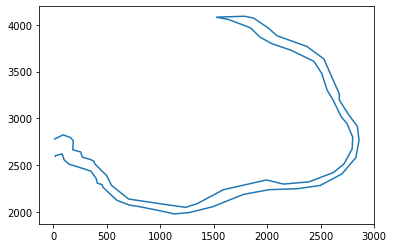

In [4]:
annotation_id = 0

region_shape_attributes = json.loads(
    df[df["filename"] == fn].region_shape_attributes[annotation_id]
)

plot(region_shape_attributes["all_points_x"],region_shape_attributes["all_points_y"])

# Draw into image

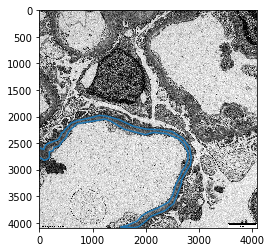

In [5]:
import skimage.io
fn_full = dataset_path / f"GBM_measurement_3000x_2020-04-03/{fn}"
img = skimage.io.imread(fn_full, as_gray=True)
plt.imshow(img, cmap="gray")
polygon_x = region_shape_attributes["all_points_x"]
polygon_y = region_shape_attributes["all_points_y"]
plot(polygon_x, polygon_y)



# Get binar mask

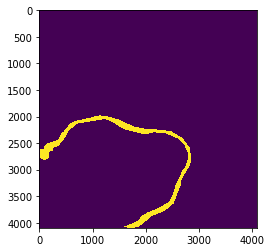

In [6]:
from matplotlib.path import Path as mplPath
polygon = list(zip(polygon_y, polygon_x))
poly_path = mplPath(polygon)

# coordinates are swapped also here
# x, y = np.mgrid[: self.region_size_on_level[1], : self.region_size_on_level[0]]
x, y = np.mgrid[
    : img.shape[0], :img.shape[1]
]
coors = np.hstack(
    (x.reshape(-1, 1), y.reshape(-1, 1))
)  # coors.shape is (4000000,2)

mask = poly_path.contains_points(coors)
mask = mask.reshape([img.shape[0], img.shape[1]])
plt.imshow(mask)

In [7]:
img.shape

(4096, 4096)

In [8]:
mask.dtype

dtype('bool')

# Segmentation

## Threshold

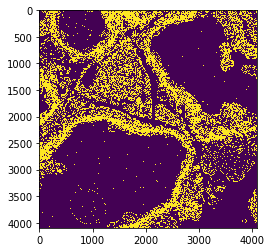

In [9]:
seg_thr = (0.2 < img) & (img < 0.5)
# print(seg.shape, seg.dtype)
plt.imshow(seg_thr)

## Stupid random

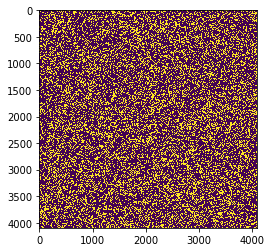

In [10]:
seg_rnd = np.random.rand(*img.shape) > 0.7
plt.imshow(seg_rnd)

# Evaluation with Jaccard (intersection over union)


https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/



In [11]:
import sklearn.metrics
print(sklearn.metrics.jaccard_score(mask.ravel(), seg_thr.ravel()))
print(sklearn.metrics.jaccard_score(mask.ravel(), seg_rnd.ravel()))

0.08551974054497324
0.025477917482829772


In [12]:
p = {"a":0}
p.get("a")

0

# Save annotation to file

In [57]:
fn
image_dir_name = "GBM_measurement_3000x_2020-04-03"
label_dir_name = "GBM_measurement_3000x_2020-04-03_label"

def prepare_label(df, dataset_path, image_dir_name, fn):
    ln = np.sum(df[df["filename"] == fn].region_shape_attributes != "{}")

    fn_full = dataset_path / f"{image_dir_name}/{fn}"
    img = skimage.io.imread(fn_full, as_gray=True)
    mask = np.zeros([img.shape[0], img.shape[1]], dtype=np.uint8)
    for annotation_id in range(ln):
#         print("-----------------")
#         print(annotation_id, ln)
        dfrsa = df[df["filename"] == fn].region_shape_attributes.values
#         print("len and dfrsa", len(dfrsa), " | ", dfrsa)
        region_shape_attributes = json.loads(
            df[df["filename"] == fn].region_shape_attributes.values[annotation_id]
        )

    #     plt.imshow(img, cmap="gray")
        polygon_x = region_shape_attributes["all_points_x"]
        polygon_y = region_shape_attributes["all_points_y"]
        print(":    ",annotation_id, polygon_x[:3], polygon_y[:3])

        polygon = list(zip(polygon_y, polygon_x))
        poly_path = mplPath(polygon)
        x, y = np.mgrid[
            : img.shape[0], :img.shape[1]
        ]
        coors = np.hstack(
            (x.reshape(-1, 1), y.reshape(-1, 1))
        )  # coors.shape is (4000000,2)

        mask_i = poly_path.contains_points(coors)
        mask_i = mask_i.reshape([img.shape[0], img.shape[1]])
    #     mask_i = mask.reshape(img.shape[:-1])
        mask[mask_i] = 255
    #     plot(region_shape_attributes["all_points_x"],region_shape_attributes["all_points_y"])
    return mask

In [14]:
mask = prepare_label(df, dataset_path, image_dir_name, fn)
if np.max(mask) > 0:
    skimage.io.imsave(dataset_path / label_dir_name / (str(fn) + ".png"), mask)

0 [15, 94, 164] [2779, 2823, 2794]
1 [4081, 4021, 3882] [2212, 2247, 2311]
2 [169, 298, 288] [5, 5, 99]
3 [5, 5, 99] [2043, 2152, 2103]


In [15]:
annotation_id

0

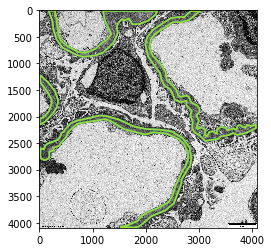

In [16]:
plt.imshow(img, cmap='gray')
plt.contour(mask)

In [17]:
mask.shape

(4096, 4096)

# All annotations in files

In [62]:
for fn in df["filename"].unique():
    print(f"filename={fn}")
    mask = prepare_label(df, dataset_path, image_dir_name, fn)
    if np.max(mask) > 0:
        skimage.io.imsave(dataset_path / label_dir_name / (str(fn) + ".png"), mask)

filename=Ma306-2-27.jpg
:     0 [15, 94, 164] [2779, 2823, 2794]
:     1 [4081, 4021, 3882] [2212, 2247, 2311]
:     2 [169, 298, 288] [5, 5, 99]
:     3 [5, 5, 99] [2043, 2152, 2103]
filename=Ma306-2-29.jpg
filename=Ma309-2-06.jpg
filename=Ma309-2-53.jpg
filename=Ma311-2-12.jpg
filename=Ma312-1-06.jpg
filename=Ma312-1-36.jpg
filename=Ma313-2-06.jpg
filename=Ma313-2-16.jpg
filename=Ma315-1-019.jpg
filename=Ma318-2-04.jpg
filename=Ma320-1-13.jpg
filename=Ma320-1-21.jpg
filename=Ma320-1-27.jpg
filename=Ma324-1- (24).jpg
filename=Ma326-3-23.jpg
filename=Ma328-2-64.jpg
filename=Ma329-1-36.jpg
filename=Ma331-2-08.jpg
filename=Ma333-2-22.jpg
filename=Ma335-1-08.jpg
filename=Ma335-1-52.jpg
filename=Ma336-2-16.jpg
filename=Ma336-2-20.jpg
filename=Ma337-1-10.jpg
filename=Ma337-1-28.jpg
filename=Ma337-1-70.jpg
filename=Ma338-3-10.jpg
filename=Ma338-3-26.jpg
filename=Ma339-1-06.jpg
filename=Ma340-1-016.jpg
filename=Ma341-1-39.jpg
filename=Ma342-2-032.jpg
filename=Ma343-1-14.jpg
filename=Ma343-1-3